In [46]:
# 2019/04/08
# Code to analyze 20190117-n37 data

In [47]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import os
import glob

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from lmfit.models import Model, ConstantModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel

sns.set_context('talk')

In [48]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}',
                                 '\DeclareSIUnit\gauss{G}']}
plt.rcParams.update(params)

# Some constant variables

In [49]:
# List of files to glob
POL_LIST = glob.glob('n34-interleaved-all_dimers-Pol*_out.csv')
UNPOL_LIST = glob.glob('n34-interleaved-all_dimers-Unpol*_out.csv')

SET_NAME = '20190123-n34'
POL_NAME = '20190123-n34p'
UNPOL_NAME = '20190123-n34u'

ATOMIC = 1401.71
ZEEMAN = 1.60839
ORDER = -1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

# Retrieve files and do some preprocessing

### Retrieve all the data files and put in to a single DataFrame

In [50]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

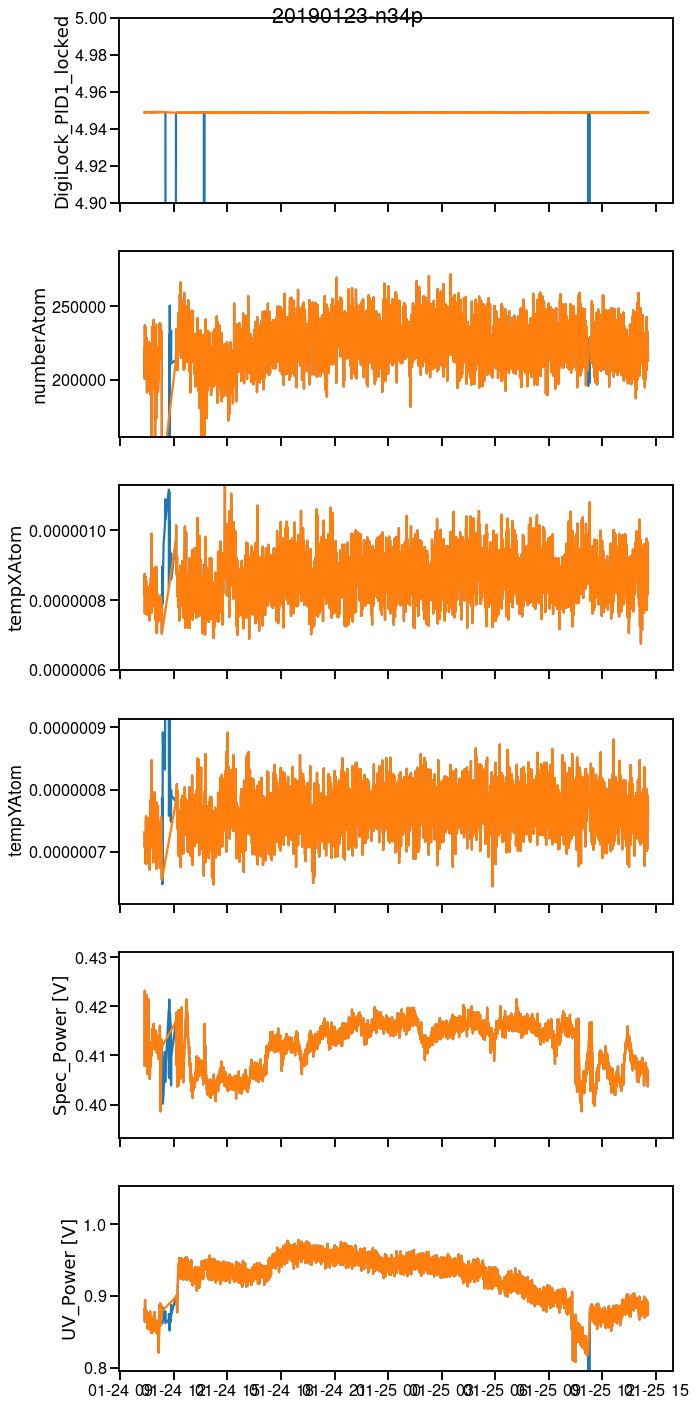

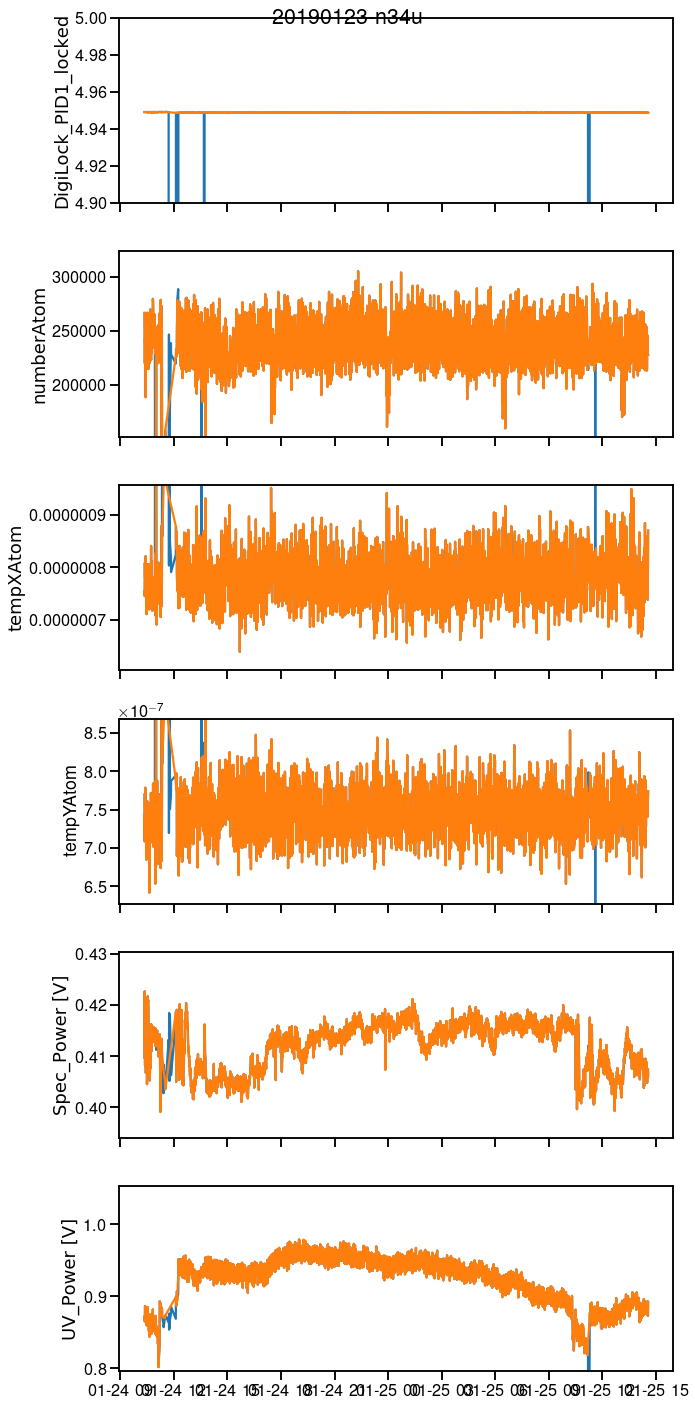

In [51]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where atom number was above/below cutoff
    df_reduced = df_reduced[(100e3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 400e3)]
    
    # Remove data where tempYAtom was above/below cutoff
    df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax]= plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name)

        ax[0].set_ylabel('DigiLock_PID1_locked', usetex=False)
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel('numberAtom', usetex=False)
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel('tempXAtom', usetex=False)
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel('tempYAtom')
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel('Spec_Power [V]', usetex=False)
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel('UV_Power [V]', usetex=False)
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

In [52]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std]})
    
    df_out['count'] = df_grouped.size().values
    
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

### Adjust counts due to MCP saturation

In [53]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

### Calculate detunings

In [54]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

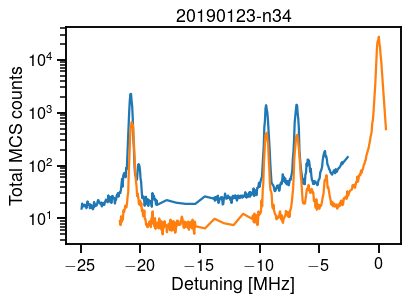

In [55]:
plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'])
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'])
plt.yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.show()

# Analyzing the data

In [56]:
pol_data = pol_out
unpol_data = unpol_out

### Adjust counts based on 689 nm and UV intensities

In [57]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

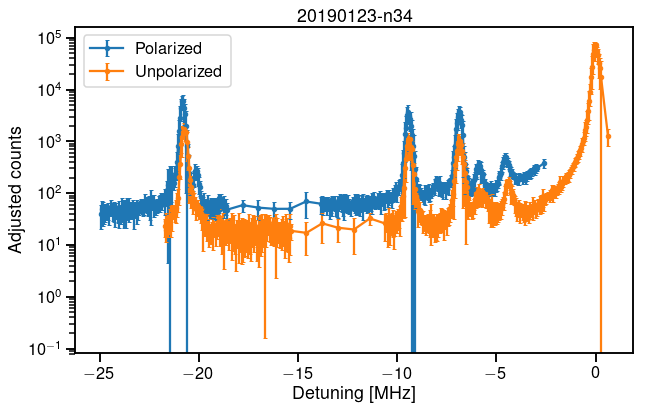

In [58]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized')
plt.gca().set_yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Adjusted counts')
plt.legend()
plt.show()

### Plots for DAMOP 2019

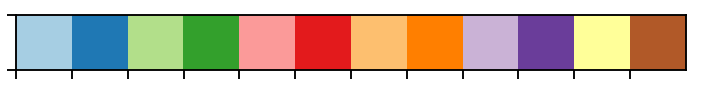

In [59]:
sns.palplot(sns.color_palette("Paired"))

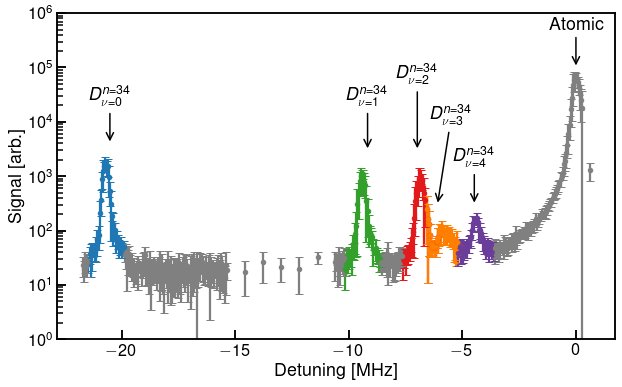

In [60]:
# Plot ranges and colors
D0_center_ex = -20.7206707 # Fitted position
D1_center_ex = -9.41763420 # Fitted position
D2_center_ex = -6.85418017 # Fitted position
D3_center_ex = -5.79142391 # Fitted position
D4_center_ex = -4.41051802 # Fitted position

D0_center_th = -20.533029820674397 # Theory position
D1_center_th = -9.1806880886635369 # Theory position
D2_center_th = -6.9896165107818060 # Theory position
D3_center_th = -6.1012672001143731 # Theory position
D4_center_th = -4.4783279344057858 # Theory position

width = 0.8
state = [[r'$\nu=0$', D0_center_ex-width, D0_center_ex+width, sns.color_palette("Paired")[1]],
         [r'$\nu=1$', D1_center_ex-width, D1_center_ex+width, sns.color_palette("Paired")[3]],
         [r'$\nu=2$', D2_center_ex-width, D2_center_ex+width, sns.color_palette("Paired")[5]],
         [r'$\nu=3$', D3_center_ex-width, D3_center_ex+width, sns.color_palette("Paired")[7]],
         [r'$\nu=4$', D4_center_ex-width, D4_center_ex+width, sns.color_palette("Paired")[9]]]

plt.figure(figsize=(10,6))
#plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
#             yerr=pol_data['sfiIntegral_adjusted', 'std'],
#             fmt='.-', capsize=2, label='Polarized')

# Plot colored vibrational states
for i in state:
    i_label = i[0]
    i_lower = i[1]
    i_upper = i[2]
    i_color = i[3]
    i_xdata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['detuning']
    i_ydata = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'mean']
    i_yerr = unpol_data[(i_lower <= unpol_data['detuning']) & (unpol_data['detuning'] <= i_upper)]['sfiIntegral_adjusted', 'std']
    plt.errorbar(i_xdata, i_ydata, yerr=i_yerr, fmt='.', capsize=4, label=i_label, color=i_color)

# Plotting all the other data
r_xdata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['detuning']
r_ydata = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'mean']
r_yerr = unpol_data[~((state[0][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[0][2]))
                     &~((state[1][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[1][2]))
                     &~((state[2][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[2][2]))
                     &~((state[3][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[3][2]))
                     &~((state[4][1] <= unpol_data['detuning']) & (unpol_data['detuning'] <= state[4][2]))]['sfiIntegral_adjusted', 'std']

plt.errorbar(r_xdata, r_ydata, yerr=r_yerr, fmt='.', capsize=4, label=i_label, color='grey')

ax = plt.gca()

# Axis options
ax.set_yscale('log')
ax.set_ylim((1, 1E6))

# Tick options
ax.tick_params(which='both', axis='both', direction='in')

#plt.title(SET_NAME)

plt.xlabel('Detuning [MHz]')
plt.ylabel('Signal [arb.]')

#plt.legend(frameon=False)

# Text labels
text_kwargs = {'fontsize':18,
               'ha':'center'}

arrow_props = {'arrowstyle':'->'}

# Atomic line
xpos = 0
ypos = 1E5
plt.annotate(s=r'Atomic', xy=(xpos, ypos), xytext=(xpos, ypos*5), 
             arrowprops=arrow_props, **text_kwargs)

# D0
xpos = D0_center_th
ypos = 4E3
plt.annotate(s=r'$D_{\nu=0}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, ypos*5), 
             arrowprops=arrow_props, **text_kwargs)

# D1
xpos = D1_center_th
ypos = 3E3
plt.annotate(s=r'$D_{\nu=1}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, 2E4),
             arrowprops=arrow_props, **text_kwargs)

# D2
xpos = D2_center_th
ypos = 3E3
plt.annotate(s=r'$D_{\nu=2}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, 5E4),
             arrowprops=arrow_props, **text_kwargs)

# D3
xpos = D3_center_th
ypos = 3E2
plt.annotate(s=r'$D_{\nu=3}^{n=34}$', xy=(xpos, ypos), xytext=(-5.5, 9E3),
             arrowprops=arrow_props, **text_kwargs)

# D4
xpos = D4_center_th
ypos = 3E2
plt.annotate(s=r'$D_{\nu=4}^{n=34}$', xy=(xpos, ypos), xytext=(xpos, ypos*5),
             arrowprops=arrow_props, **text_kwargs)

#plt.savefig('n34_unpolarized.png', bbox_inches='tight', transparent=False, dpi=1000)

plt.show()

### Plots for PhD thesis

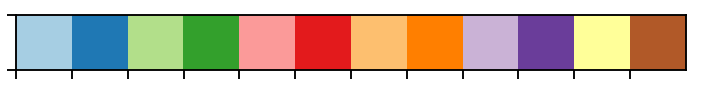

In [66]:
sns.palplot(sns.color_palette("Paired"))

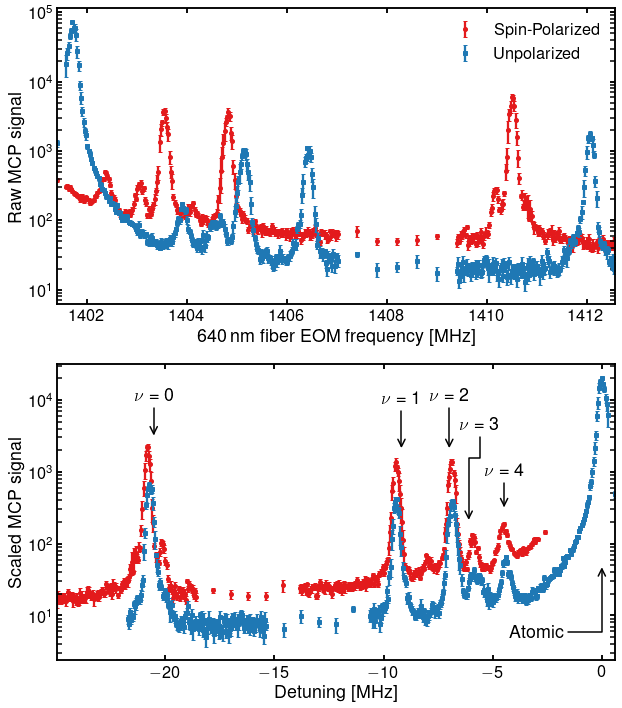

In [157]:
[fig, axs] = plt.subplots(nrows=2, ncols=1, figsize=(10,12), sharex=False)

###############################################
# Plot options
cp = sns.color_palette("Paired")

pol_data_opt = {'fmt':'o',
                'markersize':4,
                'capsize':2,
                'color':cp[5]}

pol_fit_opt = {'color':cp[5]}

unpol_data_opt = {'fmt':'s',
                  'markersize':4,
                  'capsize':2,
                  'color':cp[1]}

unpol_fit_opt = {'color':cp[1]}

###############################################
# Plotting the "raw" MCP signal

# Polarized data
x = pol_data['imagevcoAtom']
y = pol_data['sfiIntegral_adjusted','mean']
y_unc = pol_data['sfiIntegral_adjusted','std']/np.sqrt(pol_data['count'])
axs[0].errorbar(x, y, yerr=y_unc, label=r'Spin-Polarized', **pol_data_opt, zorder=1)

# Unpolarized data
x = unpol_data['imagevcoAtom']
y = unpol_data['sfiIntegral_adjusted','mean']
y_unc = unpol_data['sfiIntegral_adjusted','std']/np.sqrt(pol_data['count'])
axs[0].errorbar(x, y, yerr=y_unc, label=r'Unpolarized', **unpol_data_opt, zorder=2)

###############################################
# Plotting the scaled MCP signal (scaled for intensities and saturation)

# Polarized data
x = pol_data['detuning']
y = pol_data['sfiIntegral','mean']
y_unc = pol_data['sfiIntegral','std']/np.sqrt(pol_data['count'])
axs[1].errorbar(x, y, yerr=y_unc, label=r'Polarized', **pol_data_opt, zorder=1)

# Unpolarized data
x = unpol_data['detuning']
y = unpol_data['sfiIntegral','mean']
y_unc = unpol_data['sfiIntegral','std']/np.sqrt(pol_data['count'])
axs[1].errorbar(x, y, yerr=y_unc, label=r'Unpolarized', **unpol_data_opt, zorder=2)

##################################
# Labeling scaled data dimer lines

# Experimental Line positions
D0_center_ex = -20.7206707 # Fitted position
D1_center_ex = -9.41763420 # Fitted position
D2_center_ex = -6.85418017 # Fitted position
D3_center_ex = -5.79142391 # Fitted position
D4_center_ex = -4.41051802 # Fitted position

# Theory Line positions
D0_center_th = -20.533029820674397 # Theory position
D1_center_th = -9.1806880886635369 # Theory position
D2_center_th = -6.9896165107818060 # Theory position
D3_center_th = -6.1012672001143731 # Theory position
D4_center_th = -4.4783279344057858 # Theory position

# Text labels
text_kwargs = {'fontsize':18,
               'ha':'center'}

arrow_props = {'arrowstyle':'->'}

# Atomic line
arrow_props_A = arrow_props
arrow_props_A['connectionstyle']="angle,angleA=0,angleB=90,rad=0"
xpos = 0
ypos = 5E1
axs[1].annotate(s=r'Atomic', xy=(xpos, ypos), xytext=(-3, 5), arrowprops=arrow_props_A, **text_kwargs)

# D0
xpos = D0_center_th
ypos = 3E3
axs[1].annotate(s=r'$\nu=0$', xy=(xpos, ypos), xytext=(xpos, 1E4), arrowprops=arrow_props, **text_kwargs)

# D1
xpos = D1_center_th
ypos = 2E3
axs[1].annotate(s=r'$\nu=1$', xy=(xpos, ypos), xytext=(xpos, 9E3), arrowprops=arrow_props, **text_kwargs)

# D2
xpos = D2_center_th
ypos = 2E3
axs[1].annotate(s=r'$\nu=2$', xy=(xpos, ypos), xytext=(xpos, 1E4), arrowprops=arrow_props, **text_kwargs)

# D3
arrow_props_D3 = arrow_props
arrow_props_D3['connectionstyle']="bar,angle=180,fraction=-0.35"
xpos = D3_center_th
ypos = 2E2
axs[1].annotate(s=r'$\nu=3$', xy=(xpos, ypos), xytext=(xpos+0.5, 4E3), arrowprops=arrow_props_D3, **text_kwargs)

# D4
xpos = D4_center_th
ypos = 3E2
axs[1].annotate(s=r'$\nu=4$', xy=(xpos, ypos), xytext=(xpos, 9E2), arrowprops=arrow_props, **text_kwargs)

##################################
# Figure options

for ax in axs:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', direction='in', length=5,
                   bottom=True, left=True, top=True, right=True)

# Axis limits
axs[0].set_xlim(min([min(pol_data['imagevcoAtom']), min(unpol_data['imagevcoAtom'])]),
                max([max(pol_data['imagevcoAtom']), max(unpol_data['imagevcoAtom'])]))
axs[1].set_xlim(min([min(pol_data['detuning']), min(unpol_data['detuning'])]),
                max([max(pol_data['detuning']), max(unpol_data['detuning'])]))


# Axis labels
axs[0].set_xlabel(r'\SI{640}{\nm} fiber EOM frequency [\si{\MHz}]')
axs[0].set_ylabel('Raw MCP signal')
axs[1].set_xlabel(r'Detuning [\si{\MHz}]')
axs[1].set_ylabel('Scaled MCP signal')

# Plot legend
axs[0].legend(frameon=False)

plt.savefig('n34-excited_dimer_signal.pdf', bbox_inches='tight')

plt.show()

## Fitting the data

### n=34, polarized sample

#### n=34, polarized, dimer, ground state

[[Model]]
    ((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 548
    # data points      = 89
    # variables        = 9
    chi-square         = 306273.541
    reduced chi-square = 3828.41926
    Akaike info crit   = 742.780181
    Bayesian info crit = 765.177908
[[Variables]]
    bg_c0:         51.6264947 +/- 9.23762802 (17.89%) (init = 43.95377)
    d0_fraction:   0.33372696 +/- 0.04350721 (13.04%) (init = 0.5)
    d0_sigma:      0.12468205 +/- 0.00126112 (1.01%) (init = 0.1)
    d0_center:    -20.8172163 +/- 8.4110e-04 (0.00%) (init = -20.82)
    d0_amplitude:  1773.14581 +/- 28.2345455 (1.59%) (init = 1768)
    dx_fraction:   1.3753e-07 +/- 3.21206220 (2335575573.69%) (init = 0.5)
    dx_sigma:      0.10602656 +/- 0.03231311 (30.48%) (init = 0.1)
    dx_center:    -20.1256538 +/- 0.02341018 (0.12%) (init = -20.13)
    dx_amplitude:  42.7678764 +/- 25.2206944

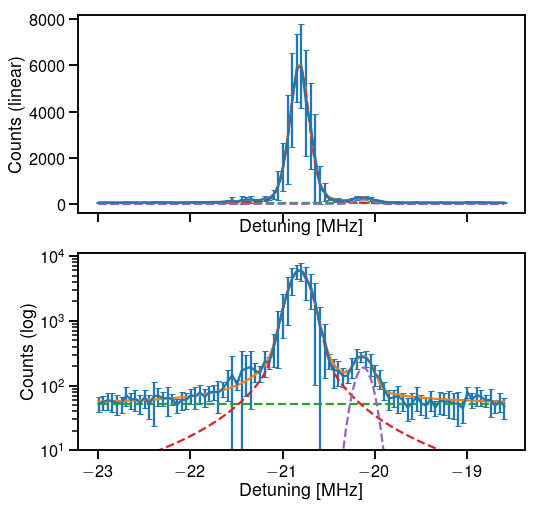

In [228]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -23
xmax = -18

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + d0 + dx
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-20.82, vary=True)
fit_params['d0_amplitude'].set(1768, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-20.13, vary=True)
fit_params['dx_amplitude'].set(43, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

pol_D0_fit_result = fit_result

In [230]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_pol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

pol_D0_center = fit_result.params['d0_center'].value

Xmin [MHz]:	-22.996779999999944
Xmax [MHz]:	-18.596780000000308
numberAtom(mean):	222583.34323836278
numberAtom(std):	6272.861207905375
tempXAtom(mean):	8.701982711276086e-07
tempXAtom(std):	2.2990587339095087e-08
tempYAtom(mean):	7.686774121990368e-07
tempYAtom(std):	1.3895597598841297e-08
UV_Power(mean):	0.9276738884743677
UV_Power(std):	0.004423915974034248
Spec_Power(mean):	0.41168399767929253
Spec_Power(std):	0.000989340790924547


#### n=34, polarized, dimer, 1st and 2nd excited states

[[Model]]
    ((((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_')) + Model(pvoigt, prefix='d3_')) + Model(pvoigt, prefix='d4_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 952
    # data points      = 163
    # variables        = 23
    chi-square         = 683379.389
    reduced chi-square = 4881.28135
    Akaike info crit   = 1405.59201
    Bayesian info crit = 1476.74826
[[Variables]]
    bg_c0:         50 (fixed)
    a_fraction:    0.52147737 +/- 38125.2826 (7311013.84%) (init = 0.5)
    a_sigma:       0.10084013 +/- 18.2809071 (18128.60%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:   125418.634 +/- 9.1699e+09 (7311446.31%) (init = 120226)
    d1_fraction:   0.30405918 +/- 0.07518203 (24.73%) (init = 0.5)
    d1_sigma:      0.14008070 +/- 0.00267788 (1.91%) (init = 0.1)
    d1_center:    -9.42690144 +/- 0.00176103 (0.02%) (init

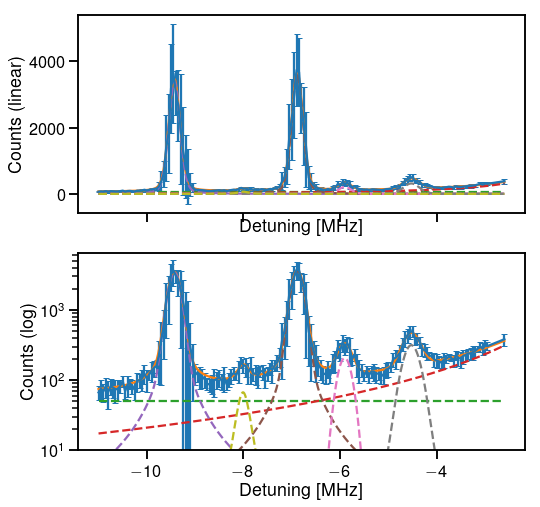

In [231]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -11
xmax = -2

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
d3 = PseudoVoigtModel(prefix='d3_')
d4 = PseudoVoigtModel(prefix='d4_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + a + d1 + d2 + d3 + d4 + dx
fit_params = fit_model.make_params()

#fit_params['bg_c0'].set(min(ydata), max=100, vary=True)
fit_params['bg_c0'].set(50, max=100, vary=False)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(120226, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-9.43, vary=True)
fit_params['d1_amplitude'].set(1120, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-8, vary=True)
fit_params['dx_amplitude'].set(24, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-6.88, vary=True)
fit_params['d2_amplitude'].set(1172, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

fit_params['d3_center'].set(-5.90, vary=True)
fit_params['d3_amplitude'].set(70, min=0, vary=True)
fit_params['d3_sigma'].set(0.1, min=0, vary=True)

fit_params['d4_center'].set(-4.5, vary=True)
fit_params['d4_amplitude'].set(140, min=0, vary=True)
fit_params['d4_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

pol_Dnu_fit_result = fit_result

In [232]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_pol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_pol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_pol_N = d1_pol_N
d2_pol_Ty = d1_pol_Ty

pol_D1_center = fit_result.params['d1_center'].value
pol_D2_center = fit_result.params['d2_center'].value
pol_D3_center = fit_result.params['d3_center'].value
pol_D4_center = fit_result.params['d4_center'].value

Xmin [MHz]:	-10.996779999999944
Xmax [MHz]:	-2.596780000000308
numberAtom(mean):	224063.5508691206
numberAtom(std):	5309.637451519043
tempXAtom(mean):	8.630643451857537e-07
tempXAtom(std):	2.1359434233831653e-08
tempYAtom(mean):	7.643560854635309e-07
tempYAtom(std):	1.197477420487642e-08
UV_Power(mean):	0.9195828298036952
UV_Power(std):	0.005346740567212202
Spec_Power(mean):	0.4123875088161893
Spec_Power(std):	0.0007803041792006156


### n=34, unpolarized sample

#### n=34, unpolarized, dimer, ground state

[[Model]]
    ((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 213
    # data points      = 75
    # variables        = 9
    chi-square         = 89298.7636
    reduced chi-square = 1353.01157
    Akaike info crit   = 549.169111
    Bayesian info crit = 570.026504
[[Variables]]
    bg_c0:         22.0867293 +/- 7.94838597 (35.99%) (init = 13.08799)
    d0_fraction:   2.3575e-09 +/- 0.09682329 (4106997079.54%) (init = 0.5)
    d0_sigma:      0.14911997 +/- 0.00297031 (1.99%) (init = 0.1)
    d0_center:    -20.7206707 +/- 0.00235484 (0.01%) (init = -20.72)
    d0_amplitude:  537.644478 +/- 29.4567598 (5.48%) (init = 537)
    dx_fraction:   0.99999993 +/- 0.27192818 (27.19%) (init = 0.5)
    dx_sigma:      0.20998799 +/- 0.19379388 (92.29%) (init = 0.1)
    dx_center:    -20.2789609 +/- 0.11191130 (0.55%) (init = -20.13)
    dx_amplitude:  36.7142026 +/- 39.4727113 

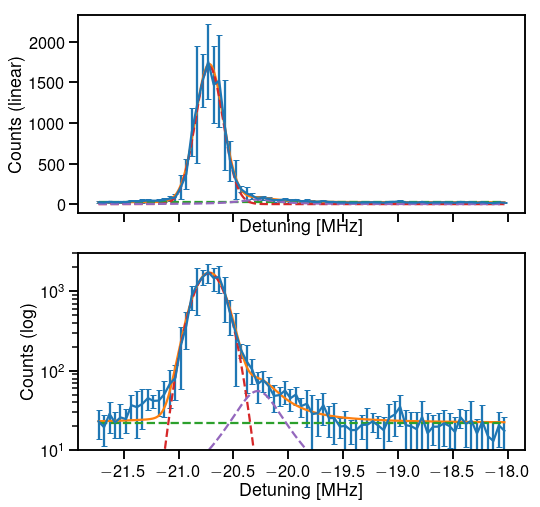

In [233]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -23
xmax = -18

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + d0 + dx
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-20.72, vary=True)
fit_params['d0_amplitude'].set(537, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-20.13, vary=True)
fit_params['dx_amplitude'].set(43, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

unpol_D0_fit_result = fit_result

In [234]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_unpol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                    np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                     np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

unpol_D0_center = fit_result.params['d0_center'].value

Xmin [MHz]:	-21.730000000000018
Xmax [MHz]:	-18.029999999999745
numberAtom(mean):	236972.1669761904
numberAtom(std):	7066.952489275818
tempXAtom(mean):	7.762480809285712e-07
tempXAtom(std):	1.5321021641661394e-08
tempYAtom(mean):	7.464523365238096e-07
tempYAtom(std):	1.1559748156194414e-08
UV_Power(mean):	0.9307103445870534
UV_Power(std):	0.0032845882302442193
Spec_Power(mean):	0.412344950358073
Spec_Power(std):	0.0005284468800258397


#### n=34, unpolarized, dimer, 1st and 2nd excited states

[[Model]]
    (((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_')) + Model(pvoigt, prefix='d3_')) + Model(pvoigt, prefix='d4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1043
    # data points      = 173
    # variables        = 20
    chi-square         = 85078.2253
    reduced chi-square = 556.066832
    Akaike info crit   = 1112.26002
    Bayesian info crit = 1175.32586
[[Variables]]
    bg_c0:         19.4542194 +/- 6.63266770 (34.09%) (init = 50)
    a_fraction:    0.51910963 +/- 41599.2340 (8013573.89%) (init = 0.5)
    a_sigma:       0.01680476 +/- 57.4150210 (341659.22%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:   131371.619 +/- 1.0554e+10 (8033795.95%) (init = 120226)
    d1_fraction:   0.07752744 +/- 0.11689258 (150.78%) (init = 0.5)
    d1_sigma:      0.15580455 +/- 0.00284692 (1.83%) (init = 0.1)
    d1_center:    -9.41763420 +/- 0.00202821 (0.02%

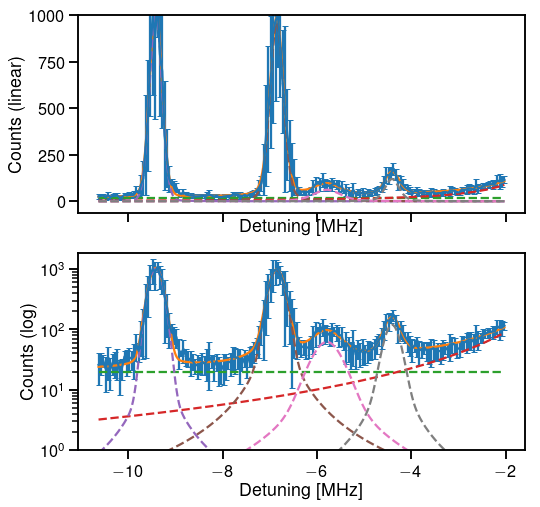

In [235]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -11
xmax = -2

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
d3 = PseudoVoigtModel(prefix='d3_')
d4 = PseudoVoigtModel(prefix='d4_')

fit_model = bg + a + d1 + d2 + d3 + d4
fit_params = fit_model.make_params()

#fit_params['bg_c0'].set(min(ydata), max=100, vary=True)
fit_params['bg_c0'].set(50, max=100, vary=True)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(120226, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-9.43, vary=True)
fit_params['d1_amplitude'].set(1120, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-6.88, vary=True)
fit_params['d2_amplitude'].set(1172, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

fit_params['d3_center'].set(-5.90, vary=True)
fit_params['d3_amplitude'].set(70, min=0, vary=True)
fit_params['d3_sigma'].set(0.1, min=0, vary=True)

fit_params['d4_center'].set(-4.5, vary=True)
fit_params['d4_amplitude'].set(140, min=0, vary=True)
fit_params['d4_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')
axs[0].set_ylim(top=1000)

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

unpol_Dnu_fit_result = fit_result

In [236]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_unpol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_unpol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_unpol_N = d1_pol_N
d2_unpol_Ty = d1_pol_Ty

unpol_D1_center = fit_result.params['d1_center'].value
unpol_D2_center = fit_result.params['d2_center'].value
unpol_D3_center = fit_result.params['d3_center'].value
unpol_D4_center = fit_result.params['d4_center'].value

Xmin [MHz]:	-10.63000000000011
Xmax [MHz]:	-2.0299999999997453
numberAtom(mean):	240271.82945109645
numberAtom(std):	7426.91348358947
tempXAtom(mean):	7.795558684994036e-07
tempXAtom(std):	1.4724048355189405e-08
tempYAtom(mean):	7.48010784647674e-07
tempYAtom(std):	9.851130129112627e-09
UV_Power(mean):	0.9240359780153816
UV_Power(std):	0.006353256921560357
Spec_Power(mean):	0.4121370252025974
Spec_Power(std):	0.0006952659579619279


# Some uncertainty calculations

In [192]:
d0_pol_int_corr = d0_pol_int/(d0_pol_N**2/d0_pol_Ty**(3/2))
d1_pol_int_corr = d1_pol_int/(d1_pol_N**2/d1_pol_Ty**(3/2))
d2_pol_int_corr = d2_pol_int/(d2_pol_N**2/d2_pol_Ty**(3/2))

d0_unpol_int_corr = d0_unpol_int/(d0_unpol_N**2/d0_unpol_Ty**(3/2))
d1_unpol_int_corr = d1_unpol_int/(d1_unpol_N**2/d1_unpol_Ty**(3/2))
d2_unpol_int_corr = d2_unpol_int/(d2_unpol_N**2/d2_unpol_Ty**(3/2))

In [193]:
d1_pol_int_corr/d0_pol_int_corr
d2_pol_int_corr/d0_pol_int_corr

d1_unpol_int_corr/d0_unpol_int_corr
d2_unpol_int_corr/d0_unpol_int_corr

0.8188255079137765+/-0.08996764263079855

# Fitting plots for PhD thesis

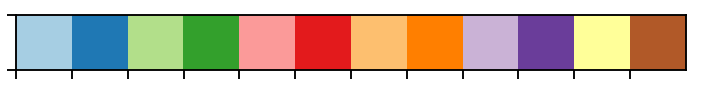

In [209]:
sns.palplot(sns.color_palette("Paired"))

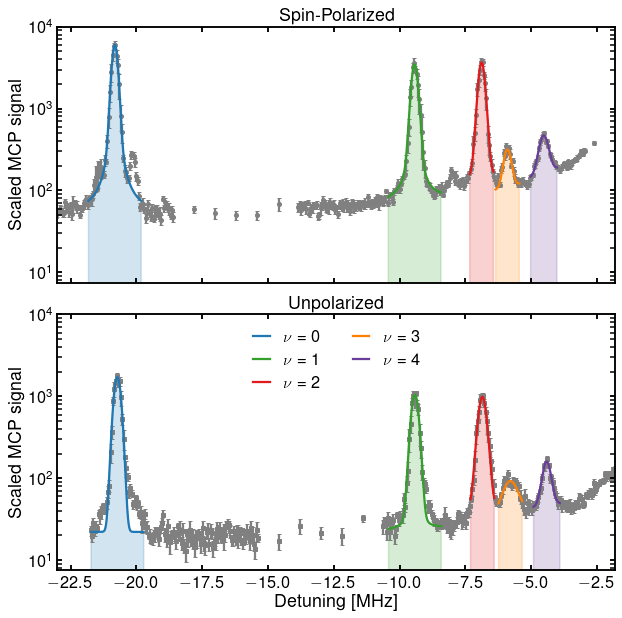

In [331]:
sns.set_context('talk')
[fig, axs] = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True)

###############################################
# Plot options
cp = sns.color_palette("Paired")

pol_data_opt = {'fmt':'o',
                'markersize':4,
                'capsize':2,
                'color':'grey',
                'zorder':1}

unpol_data_opt = {'fmt':'s',
                  'markersize':4,
                  'capsize':2,
                  'color':'grey',
                  'zorder':1}

D0_fit_opt = {'color':cp[1],
              'zorder':2}
D0_fill_opt = {'color':cp[1],
               'alpha':0.2,
               'zorder':0}

D1_fit_opt = {'color':cp[3],
              'zorder':2}
D1_fill_opt = {'color':cp[3],
               'alpha':0.2,
               'zorder':0}

D2_fit_opt = {'color':cp[5],
              'zorder':2}
D2_fill_opt = {'color':cp[5],
               'alpha':0.2,
               'zorder':0}

D3_fit_opt = {'color':cp[7],
              'zorder':2}
D3_fill_opt = {'color':cp[7],
               'alpha':0.2,
               'zorder':0}

D4_fit_opt = {'color':cp[9],
              'zorder':2}
D4_fill_opt = {'color':cp[9],
               'alpha':0.2,
               'zorder':0}

###############################################
# Plotting polarized signal and fits

data = pol_data
xdata = data['detuning']
ydata = data['sfiIntegral_adjusted', 'mean']
ydata_unc = data['sfiIntegral_adjusted', 'std']/np.sqrt(data['count'])
axs[0].errorbar(xdata, ydata, yerr=ydata_unc, **pol_data_opt, label=None)

# D0 fit result
xfit_center = pol_D0_center
radius = 1
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = pol_D0_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'd0_'])
axs[0].plot(xfit, yfit, **D0_fit_opt)
axs[0].fill_between(xfit, 0, yfit, **D0_fill_opt)

# D1 fit result
xfit_center = pol_D1_center
radius = 1
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = pol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd1_'])
axs[0].plot(xfit, yfit, **D1_fit_opt)
axs[0].fill_between(xfit, 0, yfit, **D1_fill_opt)

# D2 fit result
xfit_center = pol_D2_center
radius = 0.45
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = pol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd2_'])
axs[0].plot(xfit, yfit, **D2_fit_opt)
axs[0].fill_between(xfit, 0, yfit, **D2_fill_opt)

# D3 fit result
xfit_center = pol_D3_center
radius = 0.45
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = pol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd3_'])
axs[0].plot(xfit, yfit, **D3_fit_opt)
axs[0].fill_between(xfit, 0, yfit, **D3_fill_opt)

# D4 fit result
xfit_center = pol_D4_center
radius = 0.5
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = pol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in fit_comps.keys())
axs[0].plot(xfit, yfit, **D4_fit_opt)
axs[0].fill_between(xfit, 0, yfit, **D4_fill_opt)

###############################################
# Plotting unpolarized signal and fits
data = unpol_data
xdata = data['detuning']
ydata = data['sfiIntegral_adjusted', 'mean']
ydata_unc = data['sfiIntegral_adjusted', 'std']/np.sqrt(data['count'])
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, **unpol_data_opt, label=None)

# D0 fit result
xfit_center = unpol_D0_center
radius = 1
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = unpol_D0_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'd0_'])
axs[1].plot(xfit, yfit, **D0_fit_opt, label=r'$\nu=0$')
axs[1].fill_between(xfit, 0, yfit, **D0_fill_opt)

# D1 fit result
xfit_center = unpol_D1_center
radius = 1
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = unpol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd1_'])
axs[1].plot(xfit, yfit, **D1_fit_opt, label=r'$\nu=1$')
axs[1].fill_between(xfit, 0, yfit, **D1_fill_opt)

# D2 fit result
xfit_center = unpol_D2_center
radius = 0.45
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = unpol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd2_'])
axs[1].plot(xfit, yfit, **D2_fit_opt, label=r'$\nu=2$')
axs[1].fill_between(xfit, 0, yfit, **D2_fill_opt)

# D3 fit result
xfit_center = unpol_D3_center
radius = 0.45
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = unpol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in ['bg_', 'a_', 'd3_'])
axs[1].plot(xfit, yfit, **D3_fit_opt, label=r'$\nu=3$')
axs[1].fill_between(xfit, 0, yfit, **D3_fill_opt)

# D4 fit result
xfit_center = unpol_D4_center
radius = 0.5
xfit = np.linspace(xfit_center-radius, xfit_center+radius, 500, endpoint=True)
fit_result = unpol_Dnu_fit_result
fit_comps = fit_result.eval_components(x=xfit)
yfit = sum(fit_comps[key] for key in fit_comps.keys())
axs[1].plot(xfit, yfit, **D4_fit_opt, label=r'$\nu=4$')
axs[1].fill_between(xfit, 0, yfit, **D4_fill_opt)

###############################################
# Figure options

for ax in axs:
    #ax.set_xlim(min([min(pol_data['detuning']), min(unpol_data['detuning'])]), max([max(pol_data['detuning']), max(unpol_data['detuning'])]))
    ax.set_xlim((-23, -1.8))
    ax.set_ylim((0.75E1, 1E4))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', direction='in', length=5,
                   bottom=True, left=True, top=True, right=True)
    
    ax.set_ylabel(r'Scaled MCP signal')

axs[1].set_xlabel(r'Detuning [\si{\MHz}]')
axs[0].title.set_text(r'Spin-Polarized')
axs[1].title.set_text(r'Unpolarized')
plt.subplots_adjust(hspace=0.125)

axs[1].legend(frameon=False, ncol=2, handlelength=1)

plt.savefig('n34-pol_unpol_fitted.pdf', bbox_inches='tight')

plt.show()